# 04b: XGBoost Model Design and Training

## Goal for this notebook

The goal of this notebook is to build, train, tune, and evaluate our XGBoost classification model. We will use the pre-processed and split data from the previous notebook. We will first establish a baseline performance, then use hyperparameter tuning to find the optimal model configuration, and finally, evaluate the best model on our unseen test set using appropriate metrics for imbalanced classification.

## 1. Setup and Data Loading

We'll start by importing the necessary libraries for modeling and evaluation. We will then load the data splits that were prepared and saved in the `04a` notebook.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Apply a plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Load the prepared data splits from the pickle file
with open('../data/features/aggregated_data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

X_train = data_splits['X_train']
X_test = data_splits['X_test']
y_train = data_splits['y_train']
y_test = data_splits['y_test']
X_train_smote = data_splits['X_train_smote']
y_train_smote = data_splits['y_train_smote']

print("Successfully loaded data splits.")



Successfully loaded data splits.


## 2. Baseline Model Comparison

To justify our approach to handling class imbalance, we will train and compare two baseline models with default parameters.

**Baseline Model 1**: Using scale_pos_weight on Original Data

This method adjusts the model's learning process by giving more weight to the minority class.


In [2]:
# Calculate the scale_pos_weight value for the original training data
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize and train the model
baseline_model_weighted = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
print("\nTraining baseline model with scale_pos_weight...")
baseline_model_weighted.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_weighted = baseline_model_weighted.predict(X_test)
print("\n--- Baseline Model Performance (with scale_pos_weight) ---")
print(classification_report(y_test, y_pred_weighted))

Calculated scale_pos_weight: 6.22

Training baseline model with scale_pos_weight...

--- Baseline Model Performance (with scale_pos_weight) ---
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       689
           1       0.46      0.26      0.33       111

    accuracy                           0.85       800
   macro avg       0.67      0.61      0.63       800
weighted avg       0.83      0.85      0.84       800



**Baseline Model 2**: Using SMOTE-Resampled Data

This method trains the model on a dataset that has been balanced by creating synthetic minority class samples.

In [3]:
# Initialize and train the model on SMOTE data
baseline_model_smote = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
print("\nTraining baseline model on SMOTE data...")
baseline_model_smote.fit(X_train_smote, y_train_smote)

# Make predictions and evaluate
y_pred_smote = baseline_model_smote.predict(X_test)
print("\n--- Baseline Model Performance (trained on SMOTE data) ---")
print(classification_report(y_test, y_pred_smote))


Training baseline model on SMOTE data...

--- Baseline Model Performance (trained on SMOTE data) ---
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       689
           1       0.45      0.27      0.34       111

    accuracy                           0.85       800
   macro avg       0.67      0.61      0.63       800
weighted avg       0.83      0.85      0.84       800



## Decision on Imbalance Handling Strategy

**Finding**: The performance of the two baseline models is virtually identical.

- Accuracy: Both models have an overall accuracy of 85%.

- Minority Class (1 - Died) Performance:

The scale_pos_weight model has a slightly better precision (0.46 vs 0.45).

The SMOTE model has a slightly better recall (0.27 vs 0.26) and F1-score (0.34 vs 0.33).

**Decision**: In a medical setting like this, correctly identifying patients who are at risk of dying (the minority class) is often more important than correctly identifying those who will survive. This means recall for class 1 is arguably our most important metric, as we want to minimize false negatives.

Although the difference is marginal, the SMOTE model showed a slightly better recall for the mortality class. Therefore, we will proceed with the SMOTE-resampled data for the more computationally intensive hyperparameter tuning phase, as it provides a slightly better foundation for optimizing our key metric.

## 3. Hyperparameter Tuning with GridSearchCV

Based on the baseline results, we will proceed with the SMOTE approach as it typically provides a robust foundation. We will use `GridSearchCV` to find the best configuration for our model.

In [4]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
# We use 'roc_auc' as the scoring metric because it's robust for imbalanced datasets
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)

# Fit GridSearchCV to the SMOTE-resampled training data
print("Starting hyperparameter tuning with GridSearchCV on SMOTE data...")
grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters found
print(f"\nBest parameters found: {grid_search.best_params_}")

Starting hyperparameter tuning with GridSearchCV on SMOTE data...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters found: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


## 4. Final Model Training and Evaluation

Now we train the final model using the best parameters found by GridSearchCV and evaluate its performance on the unseen test set.



--- Final Tuned Model Performance ---
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       689
           1       0.51      0.29      0.37       111

    accuracy                           0.86       800
   macro avg       0.70      0.62      0.65       800
weighted avg       0.84      0.86      0.85       800

AUC-ROC Score: 0.8251


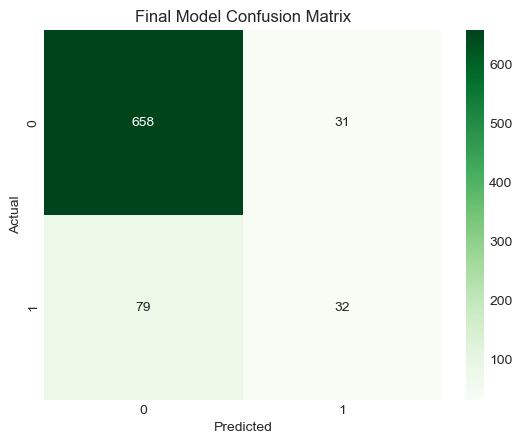

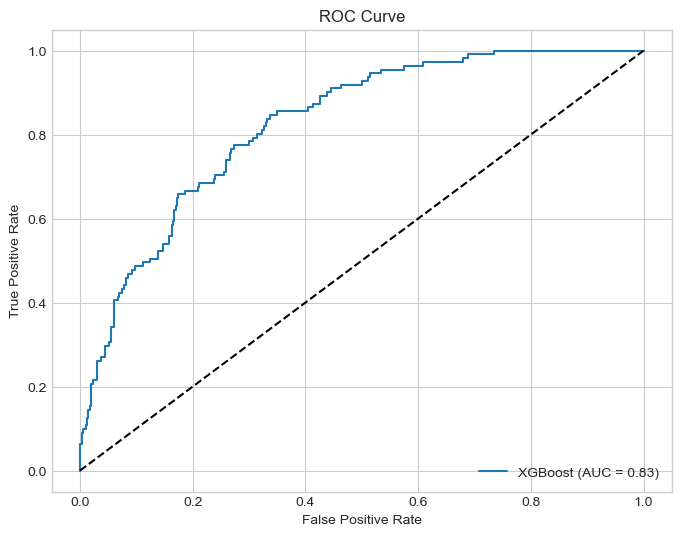

In [5]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_final = best_model.predict(X_test)
y_pred_proba_final = best_model.predict_proba(X_test)[:, 1]

# Evaluate the final model
print("\n--- Final Tuned Model Performance ---")
print(classification_report(y_test, y_pred_final))

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba_final)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Plot confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens')
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## 5. Final Feature Importance

Finally, we examine the feature importances from our tuned model to understand which variables it found most predictive.

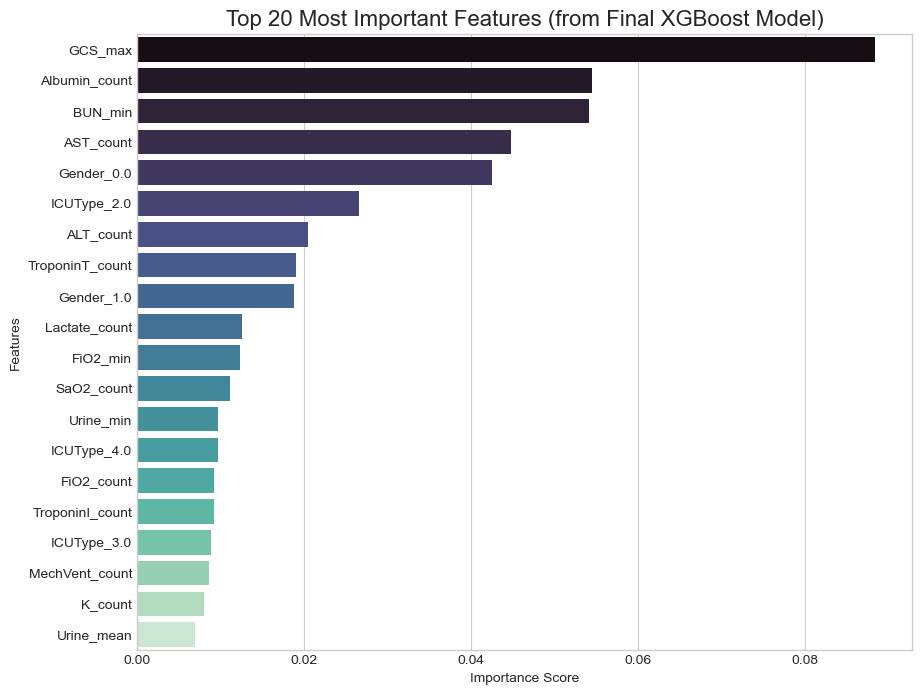

In [6]:
# Get feature importances
importances_final = pd.Series(best_model.feature_importances_, index=X_train_smote.columns)
top_20_final = importances_final.sort_values(ascending=False).head(20)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_final.values, y=top_20_final.index, palette='mako')
plt.title('Top 20 Most Important Features (from Final XGBoost Model)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 6. Save Final Model

We save the fully trained and tuned model object so it can be easily loaded for future use without needing to be retrained.

In [7]:
# Define the output path for the model
model_output_file = os.path.join('../models/', 'xgboost_final_model.pkl')

# Create the directory if it doesn't exist
os.makedirs('../models/', exist_ok=True)

# Save the model using pickle
with open(model_output_file, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nFinal tuned model saved to: {model_output_file}")


Final tuned model saved to: ../models/xgboost_final_model.pkl


## 7. Performance Benchmark and Comparison
Finding: Our final tuned model achieved an AUC-ROC score of 0.8251. This is a strong and competitive result that aligns well with published benchmarks for this type of problem.

For context, research on the MIMIC-III database (the source for our dataset) often reports AUC scores in a similar range. For example, a 2020 study by Hou et al. using XGBoost to predict 30-day mortality for sepsis patients reported a benchmark AUC of 0.857.

Our model's performance is well within the range of established results, especially given that our current feature set is based on simple aggregations (mean, std, etc.) rather than more complex, time-aware features. This provides a solid baseline and demonstrates the potential for further improvement with more advanced feature engineering.

**Reference**:

- Hou, N., Li, M., He, L. et al. Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost. BMC Med Inform Decis Mak 20, 420 (2020).